<a href="https://colab.research.google.com/github/aminkhoram/tsp/blob/main/TSP_Improve_Multi_agent_v1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps
1. Load validation set
2. load agents weights
3. calculate the performance of agents on validation-set
4. Averaging the agents
    4.1 Try different laysers (from 1 to some, or all)
    4.2 validating the diffrent layers to compare the results


In [ ]:
os.getcwd()

'C:\\Users\\amink\\TSP-improve'

In [ ]:
import os
import json
import pprint

import torch
import torch.optim as optim
from tensorboard_logger import Logger as TbLogger
from torch.utils.data import DataLoader

from nets.critic_network import CriticNetwork
from train import train_epoch, validate
from nets.reinforce_baselines import CriticBaseline
from nets.attention_model import AttentionModel
from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from utils.plots import plot_tour

import warnings
warnings.filterwarnings("ignore", category=Warning)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from time        import process_time as clock
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median

In [ ]:
# load the run args
%run options

# Set the random seed
torch.manual_seed(opts.seed)

# Optionally configure tensorboard
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.graph_size), opts.run_name))

if not os.path.exists(opts.save_dir):
    os.makedirs(opts.save_dir)

# Save arguments so exact configuration can always be found
with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
    json.dump(vars(opts), f, indent=True)

 # Set the device
opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

<Figure size 432x288 with 0 Axes>

# Dataset

Here we create a dataset shared among the solvers with the following features:

1. TSP size: 40
2. Samples = 10000,
3. Train, 9000
4. Test, 1000, Share among all the algorithms



In [ ]:
tsp_size = 40
sample_size = 10000
train = 0.9
test = 0.1
torch.manual_seed(100)

problem = load_problem(opts.problem)(
                        p_size = tsp_size, # tsp size
                        with_assert = not opts.no_assert) # if checking feasibiliy

val_dataset = problem.make_dataset(size=tsp_size,
                                   num_samples= sample_size,
                                   filename = None)


x_train, x_test = torch.utils.data.random_split(val_dataset, [9000, 1000])

initial_solutions = problem.get_initial_solutions(opts.init_val_met,x_train)


TSP with 40 nodes.


In [ ]:
#convert val-set data to complex

City = complex
def complex_tsp(tsp):
    return frozenset(City(i.numpy()[0], i.numpy()[1]) for i in tsp)

x_test_complex = []
for tsp in x_test:
    tmp = complex_tsp(tsp)
    x_test_complex.append(tmp)
x_test_complex

[frozenset({(0.012593269348144531+0.15591126680374146j),
            (0.04621565341949463+0.6872754096984863j),
            (0.05353748798370361+0.7498761415481567j),
            (0.05778312683105469+0.5830264687538147j),
            (0.13510650396347046+0.1576474905014038j),
            (0.15220677852630615+0.6868645548820496j),
            (0.15345251560211182+0.7569370865821838j),
            (0.16830438375473022+0.009708225727081299j),
            (0.20543712377548218+0.5569446086883545j),
            (0.24328964948654175+0.981354832649231j),
            (0.2759113907814026+0.14109832048416138j),
            (0.2796471118927002+0.08956873416900635j),
            (0.3377915620803833+0.9180968403816223j),
            (0.3559378385543823+0.7367296814918518j),
            (0.3565937280654907+0.004957914352416992j),
            (0.4070342183113098+0.6656370162963867j),
            (0.40801048278808594+0.2857961654663086j),
            (0.4125286936759949+0.8664000630378723j),
          

In [ ]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

In [ ]:
alltours = permutations #2-opt

def tsp_cost(sample, tour=None):
    if tour is None:
        return tour_length(tour)


    d = sample.gather(1, tour.long().unsqueeze(-1).expand_as(sample))
    length =  (d[:, 1:] - d[:, :-1]).norm(p=2, dim=2).sum(1) + (d[:, 0] - d[:, -1]).norm(p=2, dim=1)

    return length

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i])
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=123, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return frozenset(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))

In [ ]:
def plot_tour(tour, style='bo-'):
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style)
    plot_segment(start, 'rD') # start city is red Diamond.

def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')

def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

In [ ]:
## Nearest Neighbor ##

In [ ]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    tour = algorithm(cities)

    t1   = clock()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
#     print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
#           name(algorithm), len(tour), tour_length(tour), t1 - t0))
    return tour_length(tour)
def do_class(cls, algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    algorithm(cities)
    tour = cls.best_solution
    t1   = clock()
    res = []
    for k in tour:
        res.append(cities[k])
    tour = res
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
#     print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
#           name(algorithm), len(tour), tour_length(tour), t1 - t0))
    return tour_length(tour)


def name(algorithm): return algorithm.__name__.replace('_tsp', '')

In [ ]:
def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city);
    at each step extend the tour by moving from the previous city
    to its nearest neighbor that has not yet been visited."""
    C = start or first(cities)
    tour = [C]
    unvisited = set(cities - {C})
    while unvisited:
        C = nearest_neighbor(C, unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

 Mean : 6.2892118822472, Variance: 0.2981654507630591 
Wall time: 9.88 s


6.378582582832108

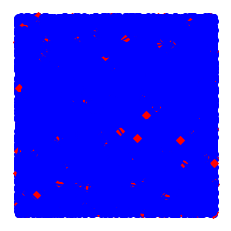

In [ ]:
%%time
import numpy as np

all_cost = []
for i in x_test_complex:
    tour_cost = do(nn_tsp, i)
    all_cost.append(tour_cost)
print(" Mean : {}, Variance: {} ".format(np.mean(all_cost), np.var(all_cost)))
do(nn_tsp, x_test_complex[0])

In [ ]:
## Simulated Annealing ##

In [ ]:
def convert_from_complex(tsp):
    res  = []
    for j in tsp:
        x = j.real
        y = j.imag
        res.append([x,y])
    return res

# def convert_from_complex(tsp):
#     index = 1
#     res  = []
#     for j in tsp:
#         x = j.real
#         y = j.imag
#         d = {'index':index, 'x':x, 'y':y}
#         res.append(d)
#     return res


UsageError: Line magic function `%%time` not found.


 Mean : 5.577301049223559, Variance: 0.1411174158543652 
Wall time: 18.6 s


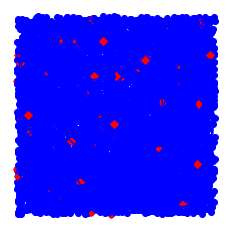

In [ ]:
%%time
import numpy as np
from anneal import SimAnneal
all_cost = []
for tsp in list(x_test_complex)[:100]:
    sa =  SimAnneal(list(convert_from_complex(tsp)), stopping_iter=5000)

    tour = do_class(sa, sa.anneal, list(tsp))
#     sa.visualize_routes()
#     sa.plot_learning()

    all_cost.append(tour)
print(" Mean : {}, Variance: {} ".format(np.mean(all_cost), np.var(all_cost)))

In [ ]:
## Ant Colony ##

In [ ]:
import math
import random
import numpy as np
from matplotlib import pyplot as plt


class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        print('Started : {0}'.format(self.mode))
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
        print('Ended : {0}'.format(self.mode))
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

#     def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
#         x = [self.nodes[i][0] for i in self.global_best_tour]
#         x.append(x[0])
#         y = [self.nodes[i][1] for i in self.global_best_tour]
#         y.append(y[0])
#         plt.plot(x, y, linewidth=line_width)
#         plt.scatter(x, y, s=math.pi * (point_radius ** 2.0))
#         plt.title(self.mode)
#         for i in self.global_best_tour:
#             plt.annotate(self.labels[i], self.nodes[i], size=annotation_size)
#         if save:
#             if name is None:
#                 name = '{0}.png'.format(self.mode)
#             plt.savefig(name, dpi=dpi)
#         plt.show()
#         plt.gcf().clear()


if __name__ == '__main__':
    _colony_size = 5
    _steps = 50
    _nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 15)]
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    acs.run()
#     acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    elitist.run()
#     elitist.plot()
    max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    max_min.run()
#     max_min.plot()


Started : ACS
Ended : ACS
Sequence : <- 4 - 12 - 6 - 14 - 7 - 10 - 2 - 8 - 9 - 1 - 5 - 11 - 3 - 15 - 13 ->
Total distance travelled to complete the tour : 3076.16

Started : Elitist
Ended : Elitist
Sequence : <- 14 - 10 - 7 - 2 - 8 - 9 - 1 - 5 - 11 - 3 - 15 - 12 - 4 - 13 - 6 ->
Total distance travelled to complete the tour : 2895.27

Started : MaxMin
Ended : MaxMin
Sequence : <- 2 - 7 - 10 - 4 - 12 - 15 - 3 - 13 - 6 - 14 - 9 - 1 - 5 - 11 - 8 ->
Total distance travelled to complete the tour : 2978.8



In [ ]:
def convert_from_complex(tsp):
    res  = []
    for j in tsp:
        x = j.real
        y = j.imag
        res.append([x,y])
    return res

In [ ]:
ac.global_best_distance

inf

In [ ]:
%%time
all_cost= []
for i in list(x_test_complex)[:2]:
    ac = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=list(convert_from_complex(i)))
    ac.run()
    dist=ac.global_best_distance
    all_cost.append(dist)
print(" Mean : {}, Variance: {} ".format(np.mean(all_cost), np.var(all_cost)))

Started : ACS
Ended : ACS
Sequence : <- 28 - 29 - 33 - 38 - 10 - 32 - 15 - 9 - 37 - 22 - 14 - 30 - 19 - 20 - 21 - 26 - 6 - 4 - 13 - 40 - 35 - 1 - 3 - 25 - 11 - 31 - 23 - 24 - 18 - 12 - 8 - 39 - 7 - 27 - 2 - 5 - 34 - 16 - 36 - 17 ->
Total distance travelled to complete the tour : 5.97

Started : ACS
Ended : ACS
Sequence : <- 31 - 1 - 19 - 38 - 39 - 10 - 4 - 22 - 33 - 35 - 18 - 16 - 12 - 25 - 2 - 15 - 29 - 7 - 13 - 5 - 21 - 32 - 3 - 23 - 36 - 9 - 20 - 17 - 24 - 6 - 27 - 34 - 37 - 30 - 28 - 8 - 26 - 11 - 40 - 14 ->
Total distance travelled to complete the tour : 4.36

 Mean : 5.164839258688289, Variance: 0.6511456047090731 
Wall time: 627 ms


In [ ]:
## LKH ##

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(name_line)? (Temp/ipykernel_13020/1569399704.py, line 45)

In [ ]:
## Divide and Conquer ##

In [ ]:
def divide_tsp(cities, n=6):
    """Find a tour by divide and conquer: if number of cities is n or less, use exhaustive search.
    Otherwise, split the cities in half, solve each half recursively,
    then join those two tours together."""
    if len(cities) <= n:
        return exhaustive_tsp(cities)
    else:
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1), divide_tsp(half2))


In [ ]:
def split_cities(cities):
    "Split cities vertically if map is wider; horizontally if map is taller."
    width  = extent(list(map(X, cities)))
    height = extent(list(map(Y, cities)))
    cities = sorted(cities, key=(X if (width > height) else Y))
    middle = len(cities) // 2
    return cities[:middle], cities[middle:]

def extent(numbers): return max(numbers) - min(numbers)

In [ ]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    return shortest_tour(s1 + s2
                         for s1 in segments1
                         for s  in segments2
                         for s2 in (s, s[::-1]))

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

In [ ]:
def improve_divide_tsp(cities): return improve_tour(divide_tsp(cities))

In [ ]:
def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it."
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True

In [ ]:
def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

In [ ]:
@cache()
def bind(fn, *extra):
    "Bind extra arguments; also assign .__name__"
    newfn = lambda *args: fn(*args, *extra)
    newfn.__name__ = fn.__name__  + ''.join(', ' + str(x) for x in extra)
    return newfn

5.8987634806324545

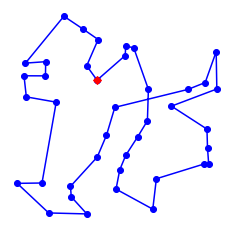

In [ ]:
do(bind(divide_tsp, 2), x_test_complex[0])

In [ ]:
%%time
# improved = divide_tsp(list(x_test_complex[0]))
# tour_length(improved)


divid_lengths = []
for i in x_test_complex:
    nn_solution = divide_tsp(i)
    t_l =  tour_length(nn_solution)
    divid_lengths.append(t_l)

print(" Mean : {}, Variance: {} ".format(np.mean(divid_lengths), np.var(divid_lengths)))

 Mean : 5.8220240359832, Variance: 0.09936559357418792 
Wall time: 18.2 s


In [ ]:
## Genetic Algorithm ##

In [ ]:
def convert_from_complex(tsp):
    res  = []
    for j in tsp:
        x = j.real
        y = j.imag
        res.append([x,y])
    return res

Generation 1: 0.012341730838763863, distance: 8.89
Generation 2: 0.012341730838763863, distance: 8.89
Generation 3: 0.012341730838763863, distance: 8.89
Generation 4: 0.013404681253091905, distance: 7.73
Generation 5: 0.013404681253091905, distance: 7.73
Generation 6: 0.013404681253091905, distance: 7.73
Generation 7: 0.014045399222429778, distance: 7.17
Generation 8: 0.014045399222429778, distance: 7.17
Generation 9: 0.014045399222429778, distance: 7.17
Generation 10: 0.014045399222429778, distance: 7.17
Generation 11: 0.014045399222429778, distance: 7.17
Generation 12: 0.014045399222429778, distance: 7.17
Generation 13: 0.014045399222429778, distance: 7.17
Generation 14: 0.014045399222429778, distance: 7.17
Generation 15: 0.014045399222429778, distance: 7.17
Generation 16: 0.014045399222429778, distance: 7.17
Generation 17: 0.014045399222429778, distance: 7.17


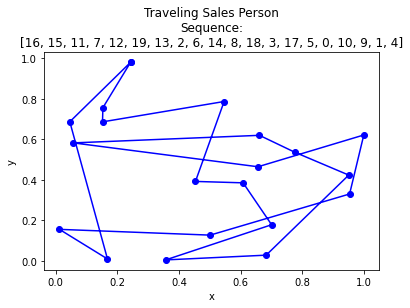

In [ ]:
from random import shuffle, random, randint
from math import sqrt, floor
import matplotlib.pyplot as plt

# constants
GENERATION_COUNT = 20
POPULATION_COUNT = 100

SATURATION_PERCENTAGE = 0.5
MUTATION_PROBABILITY = 0.9

# city coordinates
for i in list(x_test_complex)[:1]:
    coordinates = convert_from_complex(i)
# creating a path object
class Path:
    def __init__(self, sequence):
        self.sequence = sequence
        self.distance = 0
        self.fitness = 0

    def __repr__(self):
        return "{ " + f"Path: {self.sequence}, Fitness: {self.fitness}" + " }"

# initialization
# Create an initial population. This population is usually randomly generated and can be any desired size, from only a few individuals to thousands.
def initialization(path, populationCount):
    population = [path]
    for i in range(populationCount - 1):
        newPath = path.sequence[:]
        while pathExists(newPath, population):
            shuffle(newPath)
        population.append(Path(newPath))
    return population

# Returns true if the path exists and false otherwise
def pathExists(path, population):
    for item in population:
        if item.sequence == path:
            return True
    return False

# evaluation
# Each member of the population is then evaluated and we calculate a 'fitness' for that individual. The fitness value is calculated by how well it fits with our desired requirements. These requirements could be simple, 'faster algorithms are better', or more complex, 'stronger materials are better but they shouldn't be too heavy'
def calculateDistance(path):
    total = 0
    for i in range(len(path.sequence)):
        if i == len(path.sequence) - 1:
            distance = sqrt((coordinates[path.sequence[0]][0] - coordinates[path.sequence[i]][0])**2 + (
                coordinates[path.sequence[0]][1] - coordinates[path.sequence[i]][1])**2)
            total += distance
        else:
            distance = sqrt((coordinates[path.sequence[i+1]][0] - coordinates[path.sequence[i]][0])**2 + (
                coordinates[path.sequence[i+1]][1] - coordinates[path.sequence[i]][1])**2)
            total += distance
    path.distance = total
    return total

def calculateFitness(population):
    sum = 0
    for path in population:
        distance = calculateDistance(path)
        sum += 1/distance
        path.fitness = 1/distance
    for path in population:
        path.fitness /= sum
    return sorted(population, key=lambda x: x.fitness, reverse=True)

# Selection
# We want to be constantly improving our populations overall fitness. Selection helps us to do this by discarding the bad designs and only keeping the best individuals in the population. There are a few different selection methods but the basic idea is the same, make it more likely that fitter individuals will be selected for our next generation.
def select(population):
    randomNumber = random()
    third = floor(0.3 * len(population))
    randomIndex = randint(0, third)
    if randomNumber <= 0.7:
        return population[randomIndex]
    else:
        return population[randint(third+1, len(population) - 1)]

# Crossover
# During crossover we create new individuals by combining aspects of ourselected individuals. from two or more individuals we will create an even 'fitter' offspring which will inherit the best traits from We can think of this as mimicking how sex works in nature. The hope is that by combining certain traits each of its parents.
def crossOver(population):
    father = select(population)
    mother = select(population)
    while(mother == father):
        mother = select(population)
    startIndex = randint(0,len(mother.sequence) - 2)
    endIndex = randint(startIndex + 1, len(mother.sequence) - 1)
    childSequence = [None] * len(population[0].sequence)
    for i in range(startIndex, endIndex + 1):
        childSequence[i] = mother.sequence[i]
    for i in range(len(childSequence)):
        if childSequence[i] is None:
            for j in range(0, len(childSequence)):
                if father.sequence[j] not in childSequence:
                    childSequence[i] = father.sequence[j]
                    break
    return Path(childSequence)

def crossOverTwoHalfandHalf(population):
    father = select(population)
    mother = select(population)
    while(mother == father):
        mother = select(population)
    mid = len(mother.sequence) // 2
    childSequence = [None] * len(mother.sequence)
    for i in range(mid):
        childSequence[i] = mother.sequence[i]
    for i in range(mid, len(father.sequence)):
        for k in range(len(father.sequence)):
            if father.sequence[k] not in childSequence:
                childSequence[i] = father.sequence[k]
                break
    return Path(childSequence)

# Mutation
# We need to add a little bit randomness into our populations' genetics otherwise every combination of solutions we can create would be in our initial population. Mutation typically works by making very small changes at random to an individual’s genome.
def mutation(path):
    firstIndex = randint(0, len(path.sequence) - 1)
    secondIndex = randint(0, len(path.sequence) - 1)
    while secondIndex == firstIndex:
        secondIndex = randint(0, len(path.sequence) - 1)
    probability = random()
    if probability < MUTATION_PROBABILITY:
        temp = path.sequence[firstIndex]
        path.sequence[firstIndex] = path.sequence[secondIndex]
        path.sequence[secondIndex] = temp
    return path

def mutationTwoInsertion(path):
    firstIndex = randint(0, len(path.sequence) - 1)
    secondIndex = randint(0, len(path.sequence) - 1)
    while secondIndex == firstIndex:
        secondIndex = randint(0, len(path.sequence) - 1)
    probability = random()
    if probability < MUTATION_PROBABILITY:
        city = path.sequence[firstIndex]
        path.sequence.remove(path.sequence[firstIndex])
        path.sequence.insert(secondIndex, city)
    return path

# Repeat
# Now we have our next generation we can start again from step two until we reach a termination condition
def geneticAlgorithm(path, populationCount, generationCount):
    path = Path(path)
    population = initialization(path, populationCount)
    population = calculateFitness(population)
    best = population[0]
    print(f"Generation 1: {best.fitness}, distance: {round(best.distance, 2)}")
    saturation = 0
    for i in range(2, generationCount + 1):
        print(f"Generation {i}: {best.fitness}, distance: {round(best.distance, 2)}")
        newGeneration = []
        for _ in range(populationCount):
            child = crossOver(population)
            # child = crossOverTwoHalfandHalf(population)
            newGeneration.append(mutation(child))
            # newGeneration.append(mutationTwoInsertion(child))
        population = calculateFitness(newGeneration)
        if population[0].fitness > best.fitness:
            best = population[0]
            saturation = 0
        else:
            saturation += 1
        if saturation > (SATURATION_PERCENTAGE * GENERATION_COUNT):
            break
    return best

# Plotting the best path found
def plotData(path):
    x = []
    y = []
    for i in range(len(path.sequence)):
        x.append(coordinates[path.sequence[i]][0])
        y.append(coordinates[path.sequence[i]][1])
    x.append(coordinates[path.sequence[0]][0])
    y.append(coordinates[path.sequence[0]][1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Traveling Sales Person\nSequence:\n{path.sequence}")
    plt.plot(x, y, "bo-")
    plt.show()

# program entry point
if __name__ == "__main__":
    cities = list(range(20))
    best = geneticAlgorithm(cities, POPULATION_COUNT, GENERATION_COUNT)
    plotData(best)

In [ ]:
%%time

total_cost=[]
for tsp in list(x_test_complex)[:40]:
    ga=geneticAlgorithm(cities, POPULATION_COUNT, GENERATION_COUNT)
    dis=calculateDistance(ga)
    total_cost.append(dis)
print(" Mean : {}, Variance: {} ".format(np.mean(total_cost), np.var(total_cost)))

Generation 1: 0.011905297776424321, distance: 9.15
Generation 2: 0.011905297776424321, distance: 9.15
Generation 3: 0.012049731918372228, distance: 8.7
Generation 4: 0.012157124664040285, distance: 8.36
Generation 5: 0.013262698769067273, distance: 7.65
Generation 6: 0.013262698769067273, distance: 7.65
Generation 7: 0.013390383144732051, distance: 7.48
Generation 8: 0.013390383144732051, distance: 7.48
Generation 9: 0.013390383144732051, distance: 7.48
Generation 10: 0.013390383144732051, distance: 7.48
Generation 11: 0.01499535614850157, distance: 6.66
Generation 12: 0.01499535614850157, distance: 6.66
Generation 13: 0.01499535614850157, distance: 6.66
Generation 14: 0.01499535614850157, distance: 6.66
Generation 15: 0.01499535614850157, distance: 6.66
Generation 16: 0.01499535614850157, distance: 6.66
Generation 17: 0.01499535614850157, distance: 6.66
Generation 18: 0.01499535614850157, distance: 6.66
Generation 19: 0.01499535614850157, distance: 6.66
Generation 20: 0.01499535614850

Generation 17: 0.013529036652884593, distance: 7.27
Generation 18: 0.013529036652884593, distance: 7.27
Generation 19: 0.013529036652884593, distance: 7.27
Generation 20: 0.013529036652884593, distance: 7.27
Generation 1: 0.012872597161220469, distance: 8.57
Generation 2: 0.012872597161220469, distance: 8.57
Generation 3: 0.012872597161220469, distance: 8.57
Generation 4: 0.013257587069645749, distance: 7.88
Generation 5: 0.013257587069645749, distance: 7.88
Generation 6: 0.013257587069645749, distance: 7.88
Generation 7: 0.013257587069645749, distance: 7.88
Generation 8: 0.013682156833140188, distance: 7.15
Generation 9: 0.013682156833140188, distance: 7.15
Generation 10: 0.013682156833140188, distance: 7.15
Generation 11: 0.01382951382790931, distance: 6.92
Generation 12: 0.01382951382790931, distance: 6.92
Generation 13: 0.01382951382790931, distance: 6.92
Generation 14: 0.01382951382790931, distance: 6.92
Generation 15: 0.01382951382790931, distance: 6.92
Generation 16: 0.013829513

Generation 3: 0.013533493171720631, distance: 8.1
Generation 4: 0.013533493171720631, distance: 8.1
Generation 5: 0.013533493171720631, distance: 8.1
Generation 6: 0.013533493171720631, distance: 8.1
Generation 7: 0.013533493171720631, distance: 8.1
Generation 8: 0.013533493171720631, distance: 8.1
Generation 9: 0.013533493171720631, distance: 8.1
Generation 10: 0.013533493171720631, distance: 8.1
Generation 11: 0.013533493171720631, distance: 8.1
Generation 12: 0.013533493171720631, distance: 8.1
Generation 1: 0.012348141294465376, distance: 8.86
Generation 2: 0.012348141294465376, distance: 8.86
Generation 3: 0.012828309936166847, distance: 8.14
Generation 4: 0.012828309936166847, distance: 8.14
Generation 5: 0.012891641346794002, distance: 7.63
Generation 6: 0.012891641346794002, distance: 7.63
Generation 7: 0.012891641346794002, distance: 7.63
Generation 8: 0.012891641346794002, distance: 7.63
Generation 9: 0.012891641346794002, distance: 7.63
Generation 10: 0.012891641346794002, d

Generation 16: 0.013862423693411657, distance: 7.1
Generation 17: 0.013966990641604896, distance: 6.92
Generation 18: 0.014151453231912824, distance: 6.82
Generation 19: 0.014151453231912824, distance: 6.82
Generation 20: 0.014151453231912824, distance: 6.82
Generation 1: 0.012855292725015765, distance: 8.47
Generation 2: 0.012855292725015765, distance: 8.47
Generation 3: 0.012855292725015765, distance: 8.47
Generation 4: 0.012855292725015765, distance: 8.47
Generation 5: 0.012855292725015765, distance: 8.47
Generation 6: 0.01344276055341169, distance: 7.64
Generation 7: 0.01344276055341169, distance: 7.64
Generation 8: 0.01344276055341169, distance: 7.64
Generation 9: 0.01344276055341169, distance: 7.64
Generation 10: 0.01344276055341169, distance: 7.64
Generation 11: 0.01344276055341169, distance: 7.64
Generation 12: 0.014423949700223718, distance: 6.7
Generation 13: 0.014423949700223718, distance: 6.7
Generation 14: 0.014423949700223718, distance: 6.7
Generation 15: 0.01442394970022

In [ ]:
def plotData(path):
    x = []
    y = []
    for i in range(len(path.sequence)):
        x.append(coordinates[dis.sequence[i]][0])
        y.append(coordinates[dis.sequence[i]][1])
    x.append(coordinates[dis.sequence[0]][0])
    y.append(coordinates[dis.sequence[0]][1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Traveling Sales Person\nSequence:\n{path.sequence}")
    plt.plot(x, y, "bo-")
    plt.show()

# program entry point
if __name__ == "__main__":
    cities = list(range(20))
    best = geneticAlgorithm(cities, POPULATION_COUNT, GENERATION_COUNT)
    plotData(best)

Generation 1: 0.011895150758893826, distance: 9.13
Generation 2: 0.011895150758893826, distance: 9.13
Generation 3: 0.012769449972740992, distance: 8.25
Generation 4: 0.012769449972740992, distance: 8.25
Generation 5: 0.012769449972740992, distance: 8.25
Generation 6: 0.013591129208613495, distance: 7.42
Generation 7: 0.013591129208613495, distance: 7.42
Generation 8: 0.013591129208613495, distance: 7.42
Generation 9: 0.014362394164475793, distance: 7.02
Generation 10: 0.014362394164475793, distance: 7.02
Generation 11: 0.014362394164475793, distance: 7.02
Generation 12: 0.014362394164475793, distance: 7.02
Generation 13: 0.014362394164475793, distance: 7.02
Generation 14: 0.014362394164475793, distance: 7.02
Generation 15: 0.014362394164475793, distance: 7.02
Generation 16: 0.014362394164475793, distance: 7.02
Generation 17: 0.014362394164475793, distance: 7.02
Generation 18: 0.014362394164475793, distance: 7.02
Generation 19: 0.014362394164475793, distance: 7.02


AttributeError: 'float' object has no attribute 'sequence'

In [ ]:
# Reinforcement learning


10.852216104880062

# Distributed model training

In [ ]:
import argparse
import os
import time
from threading import Lock

import torch
import torch.distributed.autograd as dist_autograd
import torch.distributed.rpc as rpc
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributed.optim import DistributedOptimizer
from torchvision import datasets, transforms

# --------- MNIST Network to train, from pytorch/examples -----

class Net(nn.Module):
    def __init__(self, num_gpus=0):
        super(Net, self).__init__()
        print(f"Using {num_gpus} GPUs to train")
        self.num_gpus = num_gpus
        device = torch.device(
            "cuda:0" if torch.cuda.is_available() and self.num_gpus > 0 else "cpu")
        print(f"Putting first 2 convs on {str(device)}")
        # Put conv layers on the first cuda device, or CPU if no cuda device
        self.conv1 = nn.Conv2d(1, 32, 3, 1).to(device)
        self.conv2 = nn.Conv2d(32, 64, 3, 1).to(device)
        # Put rest of the network on the 2nd cuda device, if there is one
        if "cuda" in str(device) and num_gpus > 1:
            device = torch.device("cuda:1")

        print(f"Putting rest of layers on {str(device)}")
        self.dropout1 = nn.Dropout2d(0.25).to(device)
        self.dropout2 = nn.Dropout2d(0.5).to(device)
        self.fc1 = nn.Linear(9216, 128).to(device)
        self.fc2 = nn.Linear(128, 10).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)

        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # Move tensor to next device if necessary
        next_device = next(self.fc1.parameters()).device
        x = x.to(next_device)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# --------- Helper Methods --------------------

# On the local node, call a method with first arg as the value held by the
# RRef. Other args are passed in as arguments to the function called.
# Useful for calling instance methods. method could be any matching function, including
# class methods.
def call_method(method, rref, *args, **kwargs):
    return method(rref.local_value(), *args, **kwargs)

# Given an RRef, return the result of calling the passed in method on the value
# held by the RRef. This call is done on the remote node that owns
# the RRef and passes along the given argument.
# Example: If the value held by the RRef is of type Foo, then
# remote_method(Foo.bar, rref, arg1, arg2) is equivalent to calling
# <foo_instance>.bar(arg1, arg2) on the remote node and getting the result
# back.

def remote_method(method, rref, *args, **kwargs):
    args = [method, rref] + list(args)
    return rpc.rpc_sync(rref.owner(), call_method, args=args, kwargs=kwargs)

In [ ]:
# --------- Parameter Server --------------------
class ParameterServer(nn.Module):

    def __init__(self, num_gpus=0):
        super().__init__()
        model = Net(num_gpus=num_gpus)
        self.model = model
        self.input_device = torch.device(
            "cuda:0" if torch.cuda.is_available() and num_gpus > 0 else "cpu")


    def forward(self, inp):
        inp = inp.to(self.input_device)
        out = self.model(inp)
        # This output is forwarded over RPC, which as of 1.5.0 only accepts CPU tensors.
        # Tensors must be moved in and out of GPU memory due to this.
        out = out.to("cpu")
        return out


    # Use dist autograd to retrieve gradients accumulated for this model.
    # Primarily used for verification.
    def get_dist_gradients(self, cid):
        grads = dist_autograd.get_gradients(cid)
        # This output is forwarded over RPC, which as of 1.5.0 only accepts CPU tensors.
        # Tensors must be moved in and out of GPU memory due to this.
        cpu_grads = {}
        for k, v in grads.items():
            k_cpu, v_cpu = k.to("cpu"), v.to("cpu")
            cpu_grads[k_cpu] = v_cpu
        return cpu_grads

    # Wrap local parameters in a RRef. Needed for building the
    # DistributedOptimizer which optimizes paramters remotely.
    def get_param_rrefs(self):
        param_rrefs = [rpc.RRef(param) for param in self.model.parameters()]
        return param_rrefs

In [ ]:
# The global parameter server instance.
param_server = None
# A lock to ensure we only have one parameter server.
global_lock = Lock()


def get_parameter_server(num_gpus=0):
    """
    Returns a singleton parameter server to all trainer processes
    """
    global param_server
    # Ensure that we get only one handle to the ParameterServer.
    with global_lock:
        if not param_server:
            # construct it once
            param_server = ParameterServer(num_gpus=num_gpus)
        return param_server

def run_parameter_server(rank, world_size):
    # The parameter server just acts as a host for the model and responds to
    # requests from trainers.
    # rpc.shutdown() will wait for all workers to complete by default, which
    # in this case means that the parameter server will wait for all trainers
    # to complete, and then exit.
    print("PS master initializing RPC")
    rpc.init_rpc(name="parameter_server", rank=rank, world_size=world_size)
    print("RPC initialized! Running parameter server...")
    rpc.shutdown()
    print("RPC shutdown on parameter server.")

In [ ]:
# --------- Trainers --------------------

# nn.Module corresponding to the network trained by this trainer. The
# forward() method simply invokes the network on the given parameter
# server.
class TrainerNet(nn.Module):
    def __init__(self, num_gpus=0):
        super().__init__()
        self.num_gpus = num_gpus
        self.param_server_rref = rpc.remote(
            "parameter_server", get_parameter_server, args=(num_gpus,))

    def get_global_param_rrefs(self):
        remote_params = remote_method(
            ParameterServer.get_param_rrefs,
            self.param_server_rref)
        return remote_params

    def forward(self, x):
        model_output = remote_method(
            ParameterServer.forward, self.param_server_rref, x)
        return model_output

In [ ]:
def get_accuracy(test_loader, model):
    model.eval()
    correct_sum = 0
    # Use GPU to evaluate if possible
    device = torch.device("cuda:0" if model.num_gpus > 0
        and torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            out = model(data, -1)
            pred = out.argmax(dim=1, keepdim=True)
            pred, target = pred.to(device), target.to(device)
            correct = pred.eq(target.view_as(pred)).sum().item()
            correct_sum += correct

    print(f"Accuracy {correct_sum / len(test_loader.dataset)}")

In [ ]:
def run_training_loop(rank, num_gpus, train_loader, test_loader):
    # Runs the typical nueral network forward + backward + optimizer step, but
    # in a distributed fashion.
    net = TrainerNet(num_gpus=num_gpus)
    # Build DistributedOptimizer.
    param_rrefs = net.get_global_param_rrefs()
    opt = DistributedOptimizer(optim.SGD, param_rrefs, lr=0.03)


    for i, (data, target) in enumerate(train_loader):
        with dist_autograd.context() as cid:
            model_output = net(data)
            target = target.to(model_output.device)
            loss = F.nll_loss(model_output, target)
            if i % 5 == 0:
                print(f"Rank {rank} training batch {i} loss {loss.item()}")
            dist_autograd.backward(cid, [loss])
            # Ensure that dist autograd ran successfully and gradients were
            # returned.
            assert remote_method(
                ParameterServer.get_dist_gradients,
                net.param_server_rref,
                cid) != {}
            opt.step(cid)

    print("Training complete!")
    print("Getting accuracy....")
    get_accuracy(test_loader, net)

In [ ]:
# Main loop for trainers.
def run_worker(rank, world_size, num_gpus, train_loader, test_loader):
    print(f"Worker rank {rank} initializing RPC")
    rpc.init_rpc(
        name=f"trainer_{rank}",
        rank=rank,
        world_size=world_size)

    print(f"Worker {rank} done initializing RPC")

    run_training_loop(rank, num_gpus, train_loader, test_loader)
    rpc.shutdown()

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description="Parameter-Server RPC based training")
    parser.add_argument(
        "--world_size",
        type=int,
        default=4,
        help="""Total number of participating processes. Should be the sum of
        master node and all training nodes.""")
    parser.add_argument(
        "rank",
        type=int,
        default=None,
        help="Global rank of this process. Pass in 0 for master.")
    parser.add_argument(
        "num_gpus",
        type=int,
        default=0,
        help="""Number of GPUs to use for training, Currently supports between 0
         and 2 GPUs. Note that this argument will be passed to the parameter servers.""")
    parser.add_argument(
        "--master_addr",
        type=str,
        default="localhost",
        help="""Address of master, will default to localhost if not provided.
        Master must be able to accept network traffic on the address + port.""")
    parser.add_argument(
        "--master_port",
        type=str,
        default="29500",
        help="""Port that master is listening on, will default to 29500 if not
        provided. Master must be able to accept network traffic on the host and port.""")

    args = parser.parse_args()
    assert args.rank is not None, "must provide rank argument."
    assert args.num_gpus <= 3, f"Only 0-2 GPUs currently supported (got {args.num_gpus})."
    os.environ['MASTER_ADDR'] = args.master_addr
    os.environ["MASTER_PORT"] = args.master_port

usage: ipykernel_launcher.py [-h] [--world_size WORLD_SIZE]
                             [--master_addr MASTER_ADDR]
                             [--master_port MASTER_PORT]
                             rank num_gpus
ipykernel_launcher.py: error: argument rank: invalid int value: '/home/sirvan/.local/share/jupyter/runtime/kernel-d196824e-93b5-4f11-8bc9-9758e238df9a.json'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sirvan/anaconda3/lib/python3.9/argparse.py", line 2478, in _get_value
    result = type_func(arg_string)
ValueError: invalid literal for int() with base 10: '/home/sirvan/.local/share/jupyter/runtime/kernel-d196824e-93b5-4f11-8bc9-9758e238df9a.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sirvan/anaconda3/lib/python3.9/argparse.py", line 1853, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "/home/sirvan/anaconda3/lib/python3.9/argparse.py", line 2065, in _parse_known_args
    stop_index = consume_positionals(start_index)
  File "/home/sirvan/anaconda3/lib/python3.9/argparse.py", line 2021, in consume_positionals
    take_action(action, args)
  File "/home/sirvan/anaconda3/lib/python3.9/argparse.py", line 1914, in take_action
    argument_values = self._get_values(action, argument_strings)
  File "/home/sirvan/anaconda3

TypeError: object of type 'NoneType' has no len()

In [ ]:
processes = []
world_size = args.world_size
if args.rank == 0:
    p = mp.Process(target=run_parameter_server, args=(0, world_size))
    p.start()
    processes.append(p)
else:
    # Get data to train on
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True,)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data',
            train=False,
            transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=32,
        shuffle=True,
    )
    # start training worker on this node
    p = mp.Process(
        target=run_worker,
        args=(
            args.rank,
            world_size, args.num_gpus,
            train_loader,
            test_loader))
    p.start()
    processes.append(p)

for p in processes:
    p.join()

NameError: name 'args' is not defined